In [1]:
from keras_segmentation.predict import model_from_checkpoint_path
model=model_from_checkpoint_path("checkpoints")

loaded weights  checkpoints.00002


In [3]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Keras model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [4]:
import cv2
image_path="PMC497044_table_3.jpg"
# Reading the image
img = cv2.imread(image_path)
desired_size=512
# Resize the image while preserving aspect ratio and adding padding
height, width = img.shape[:2]
max_dim = max(height, width)
ratio = desired_size / max_dim
new_size = tuple([int(x * ratio) for x in (width, height)])
resized_img = cv2.resize(img, (new_size[0], new_size[1]))

# Adding pad to the image to get consistent shape
pad_w = desired_size - new_size[0]
pad_h = desired_size - new_size[1]
top, bottom = pad_h // 2, pad_h - (pad_h // 2)
left, right = pad_w // 2, pad_w - (pad_w // 2)
z = cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
print(top,bottom,left,right)

AttributeError: 'NoneType' object has no attribute 'shape'

In [4]:
import cv2
x=model.predict_segmentation(z)

cv2.imencode('.png', x)[1].tofile("predicted_class/PMC497044_table_3.png")
dic={1:255,2:150,3:80}

def mask_conversion(inp_dict,in_path,op_path):
    import os, cv2, numpy as np
    for png_file in os.listdir(in_path):
        if png_file.endswith(".png"):
            inp1=os.path.join(in_path,png_file)

            #load back previously created png anno images
            image_encoded = np.fromfile(inp1, dtype=np.uint8)
            # Converting dict_keys object to a list
            keys_list = list(inp_dict.keys())
            # Decode the image using cv2.imdecode
            mask = cv2.imdecode(image_encoded, cv2.IMREAD_UNCHANGED)
            for i in keys_list:
                mask[mask == i] = inp_dict[i]
            temp=os.path.join(op_path,png_file)
            cv2.imencode('.png', mask)[1].tofile(temp)

mask_conversion(dic,"predicted_class","predicted_class/process")

In [7]:
import numpy as np
import cv2

# Load the encoded image data from a file
image_encoded = np.fromfile("PMC497044_table_3.png", dtype=np.uint8)

# Decode the image using cv2.imdecode
image_decoded = cv2.imdecode(image_encoded, cv2.IMREAD_UNCHANGED)

# Initialize variables to store the coordinates of the first non-zero pixel
first_Y = None
first_X = None

# Find the coordinates (i, j) of the first non-zero pixel from the top-left
for i in range(0, 256):
    for j in range(0, 256):
        if image_decoded[i, j] > 0:
            first_Y = i - 1
            first_X = j - 1
            break
    if first_Y is not None:
        break

# Initialize variables to store the coordinates of the first non-zero pixel from the bottom-right
last_Y = None
last_X = None

# Find the coordinates (i, j) of the first non-zero pixel from the bottom-right
for i in range(255, -1, -1):
    for j in range(255, -1, -1):
        if image_decoded[i, j] > 0:
            last_Y = i + 2
            last_X = j + 2
            break
    if last_Y is not None:
        break
print(last_X,last_Y,first_X,first_Y)

x = 0
y = 0
for i in range(first_X, last_X):    
    for j in range(first_Y, last_Y):
        if image_decoded[j, i] == 0:
            y = y + 1
        else:
            x = x + 1

    # Now, outside of the inner loop for each column, check if x is less than y
    if x< y:
        for w in range(first_Y, last_Y):
            image_decoded[w, i] = 0
    x = 0
    y = 0

x = 0
y = 0
for i in range(first_Y, last_Y):
    
    for j in range(first_X, last_X):
        if image_decoded[i, j] == 0:
            y = y + 1
        else:
            x = x + 1
    if y > x:
        for w in range(first_X, last_X):
            image_decoded[i,w] = 0
    x = 0
    y = 0

top, bottom = pad_h // 4, 256 - (pad_h // 4)
left, right = pad_w // 4, 256 - (pad_w // 4)
# Crop the image
cropped_image = image_decoded[top:bottom, left:right]
# Save the modified image
cropped_image = cv2.resize(cropped_image, (width,height),interpolation=cv2.INTER_NEAREST)
cv2.imencode('.png', cropped_image)[1].tofile("temp3.png")

166 165 29 91


In [47]:
from paddleocr import PaddleOCR
import cv2
import os
import pandas as pd

# Initialize the OCR model
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Load the original image
original_image = cv2.imread("PMC1065056_table_0.jpg")

# Load the segmentation mask and perform connected component labeling
img = cv2.imread("temp3.png", cv2.IMREAD_GRAYSCALE)  # Make sure the image is grayscale
n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=4)

# Create a directory to save cropped images
output_folder = "cropped_images"
os.makedirs(output_folder, exist_ok=True)

# Create a list to store the modified bounding boxes (expanded by 3 pixels)
expanded_bounding_boxes = []
text_arr = []

# Iterate over each labeled region in the sorted order
for index in range(1, n_labels):
    area = stats[index, cv2.CC_STAT_AREA]

    # Extract the original bounding box (x, y, w, h) for the current label
    x, y, w, h = stats[index, cv2.CC_STAT_LEFT], stats[index, cv2.CC_STAT_TOP], stats[index, cv2.CC_STAT_WIDTH], stats[index, cv2.CC_STAT_HEIGHT]

    # Expand the bounding box by 3 pixels in all directions
    x -= 5
    y -= 5
    w += 10
    h += 10

    expanded_bounding_boxes.append((x, y, w, h))
bbox=[]

# Crop the original image based on the modified bounding boxes and save them
for n, (x, y, w, h) in enumerate(expanded_bounding_boxes):
    crop = original_image[y:y+h, x:x+w]

    try:
        # apply OCR using PaddleOCR
        result = ocr.ocr(crop, cls=True)
        tuples = [res[0][-1] for res in result]

        # Extract and concatenate the OCR text
        CONTENT = ""
        for tpl in tuples:
            CONTENT = CONTENT + tpl[0]
        text_arr.append(CONTENT)
    except Exception as e:
        print(f"Error processing segment {n}: {e}")
        text_arr.append("")

    # Save the cropped image
    output_path = os.path.join(output_folder, f"segment_{n}.jpg")
    cv2.imwrite(output_path, crop)

# Create a DataFrame with order numbers, filenames, and OCR text
order_numbers = list(range(len(expanded_bounding_boxes)))
data = {'Order Number': order_numbers, 'Filename': [f"segment_{i}.jpg" for i in order_numbers], 'OCR_text': text_arr}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_filename = "segmentation_info.csv"
df.to_csv(csv_filename, index=False)

print("Cropped images saved to:", output_folder)
print("CSV file saved as:", csv_filename)


[2023/09/01 04:49:38] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\rkd3d/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\rkd3d/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thre

In [48]:
from collections import Counter

# Extract the x values from the bounding boxes
x_values = [x for x, _, _, _ in expanded_bounding_boxes]

# Use Counter to count the frequency of each x value
x_counts = Counter(x_values)

# Find the maximum frequency
num_rows = max(x_counts.values())

print("Maximum frequency of the same value of x:", num_rows)


Maximum frequency of the same value of x: 11


In [49]:
from collections import Counter

# Extract the y values from the bounding boxes
y_values = [y for _, y, _, _ in expanded_bounding_boxes]

# Use Counter to count the frequency of each y value
y_counts = Counter(y_values)

# Find the maximum frequency
num_cols = max(y_counts.values())

print("Maximum frequency of the same value of y:", num_cols)


Maximum frequency of the same value of y: 8


In [19]:
from paddleocr import PaddleOCR,draw_ocr
# Paddleocr supports Chinese, English, French, German, Korean and Japanese.
# You can set the parameter `lang` as `ch`, `en`, `french`, `german`, `korean`, `japan`
# to switch the language model in order.
ocr = PaddleOCR(use_angle_cls=True, lang='en') # need to run only once to download and load model into memory
img_path = 'PMC1065056_table_0.jpg'
result = ocr.ocr(img_path, cls=True)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)

[2023/09/01 04:27:39] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\rkd3d/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\rkd3d/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thre

In [33]:
def intersection_area(box1, box2):
    # Extract coordinates for box 1
    x1, y1 = box1[0]
    x2, y2 = box1[1]
    x3, y3 = box1[2]
    x4, y4 = box1[3]

    # Extract coordinates for box 2
    x5, y5 = box2[0]
    x6, y6 = box2[1]
    x7, y7 = box2[2]
    x8, y8 = box2[3]

    # Calculate the intersection coordinates
    x_intersection = max(x1, x5)
    y_intersection = max(y1, y5)
    x2_intersection = min(x2, x6)
    y2_intersection = min(y3, y7)

    # Calculate the width and height of the intersection
    width = max(0, x2_intersection - x_intersection)
    height = max(0, y2_intersection - y_intersection)

    # Calculate the area of the intersection
    intersection_area = width * height

    return intersection_area

sample=[]
for i in expanded_bounding_boxes:
    x1 = i[0] + i[2]  # Top-right x-coordinate
    y1 = i[1]      # Top-right y-coordinate

    x2 = i[0] + i[2]  # Bottom-right x-coordinate
    y2 = i[1] + i[3]  # Bottom-right y-coordinate

    x3 = i[0]      # Bottom-left x-coordinate
    y3 = i[1] + i[3]  # Bottom-left y-coordinate
    rect1 = [[i[0], i[1]], [x1, y1], [x2, y2], [x3, y3]]
    for j in res:
        rect2=j[0]
        if intersection_area(rect1,rect2)>90:
            sample.append(j[1][0])

print(sample)


['Parameter', 'Infant', 'Pediatric', 'Adult', 'Simulated weight (kg)', '4', '7', '10', '20', '31', '50', '04', 'ETT internal diameter (mm)', '3.0', '3.5', '4.0', '5.0', '6.5', '7.0', '7.5', 'Tidal volume at 6 ml/kg (ml', '24', '42', '09', '120', '186', '300', '420', 'PEEP cmHO', '5', '5', '5', '5', '5', '5', '5', 'Rate per minute', '20', '20', '20', '20', '20', '12', '12', 'Inspiratory time (s', '1', '1', '1', '1', '1', '1.2', '1.2', 'FiO%', '21', '21', '21', '21', '21', '21', '21', 'Circuit compliance (ml/cmHO)', '1', '1', '1', '1.5', '1.5', '2.9', '29', 'Servo 300 set range', 'Neonatal', 'Pediatric', 'Adult', 'COSMOPlus sensor', 'Neonatal', 'Pediatric', 'Adult']


In [50]:
import numpy as np

# Create an empty NumPy array with the specified number of rows and columns
empty_array = np.empty((num_rows, num_cols), dtype=object)

# Fill the empty array with the content of text_arr
row, col = 0, 0  # Initialize row and column indices
for text in text_arr:
    empty_array[row, col] = text  # Fill the current cell with text
    
    # Move to the next cell, considering the array shape
    col += 1
    if col >= num_cols:
        col = 0  # Reset column index to 0
        row += 1  # Move to the next row

# Save the NumPy array to a CSV file
csv_filename = "output.csv"
np.savetxt(csv_filename, empty_array, fmt="%s", delimiter=",")

print("CSV file saved as:", csv_filename)


CSV file saved as: output.csv


In [6]:
from anno_tools.tools import padding_img
z=padding_img("PMC1079950_table_0.jpg",512)
print(z.shape)

(512, 512, 3)


In [13]:
import cv2
image_path="PMC1079950_table_0.jpg"
# Reading the image
img = cv2.imread(image_path)
desired_size=512
# Resize the image while preserving aspect ratio and adding padding
height, width = img.shape[:2]
max_dim = max(height, width)
ratio = desired_size / max_dim
new_size = tuple([int(x * ratio) for x in (width, height)])
resized_img = cv2.resize(img, (new_size[0], new_size[1]))

# Adding pad to the image to get consistent shape
pad_w = desired_size - new_size[0]
pad_h = desired_size - new_size[1]
top, bottom = pad_h // 2, pad_h - (pad_h // 2)
left, right = pad_w // 2, pad_w - (pad_w // 2)
z = cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
print(top,bottom,left,right)

115 115 0 0


In [22]:
import numpy as np
import cv2

# Load the encoded image data from a file
image_encoded = np.fromfile("PMC1079950_table_0.png", dtype=np.uint8)

# Decode the image using cv2.imdecode
image_decoded = cv2.imdecode(image_encoded, cv2.IMREAD_UNCHANGED)

# Initialize variables to store the coordinates of the first non-zero pixel
first_Y = top//2
first_X = left//2
last_Y = 256-bottom//2
last_X = 256-right//2

# Check if any non-zero pixels were found
if first_Y is not None and last_Y is not None:
    # Crop the image
    cropped_image = image_decoded[first_Y:last_Y, first_X:last_X]

cropped_image.shape[0]
# Initialize variables to store the coordinates of the first non-zero pixel
first_Y = None
first_X = None

# Find the coordinates (i, j) of the first non-zero pixel from the top-left
for i in range(0, cropped_image.shape[0]):
    for j in range(0, cropped_image.shape[1]):
        if image_decoded[i, j] > 0:
            first_Y = i - 2
            first_X = j - 2
            break
    if first_Y is not None:
        break

# Initialize variables to store the coordinates of the first non-zero pixel from the bottom-right
last_Y = None
last_X = None

# Find the coordinates (i, j) of the first non-zero pixel from the bottom-right
for i in range(cropped_image.shape[0], -1, -1):
    for j in range(cropped_image.shape[1], -1, -1):
        if image_decoded[i, j] > 0:
            last_Y = i + 2
            last_X = j + 2
            break
    if last_Y is not None:
        break

# Get the dimensions of the image
height, width = cropped_image.shape


for i in range(first_Y, last_Y):
    x = 0
    y = 0
    for j in range(first_X, last_X - 1):
        if cropped_image[j, i] == 0:
            y = y + 1
        else:
            x = x + 1

    # Now, outside of the inner loop for each column, check if x is less than y
    if x < y:
        for w in range(0, height - 1):
            cropped_image[w, i] = 0

# Get the dimensions of the image
height, width = cropped_image.shape
print(height, width)

for i in range(first_Y, last_Y):
    x = 0
    y = 0
    for j in range(first_X, last_X - 1):
        if cropped_image[i, j] == 0:
            y = y + 1
        else:
            x = x + 1
    if y > x:
        for w in range(0, width-1):
            cropped_image[i,w] = 0
            
# Save the modified image
cv2.imencode('.png', cropped_image)[1].tofile("temp3.png")


def padding_img2(refrence,image_path, desired_size):
    # Reading the image
    img = cv2.imread(refrence)
    mask= cv2.imread(image_path)
    # Ensure grayscale
    height, width = img.shape[:2]
    # Resize the image using INTER_NEAREST interpolation
    resized_img = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)

    return resized_img

z = padding_img2("PMC1079950_table_0.jpg","temp3.png", 512)
cv2.imencode('.png', z)[1].tofile("temp4.png")


IndexError: index 256 is out of bounds for axis 1 with size 256

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [5]:
import cv2
image_path="PMC1079950_table_0.jpg"
# Reading the image
img = cv2.imread(image_path)
desired_size=512
# Resize the image while preserving aspect ratio and adding padding
height, width = img.shape[:2]
max_dim = max(height, width)
ratio = desired_size / max_dim
new_size = tuple([int(x * ratio) for x in (width, height)])
resized_img = cv2.resize(img, (new_size[0], new_size[1]))

# Adding pad to the image to get consistent shape
pad_w = desired_size - new_size[0]
pad_h = desired_size - new_size[1]
top, bottom = pad_h // 2, pad_h - (pad_h // 2)
left, right = pad_w // 2, pad_w - (pad_w // 2)
z = cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
print(top,bottom,left,right)

115 115 0 0


In [2]:
import cv2

from keras_segmentation.predict import model_from_checkpoint_path
model=model_from_checkpoint_path("checkpoints")

image_path="PMC1079950_table_0.jpg"
# Reading the image
img = cv2.imread(image_path)
desired_size=512
# Resize the image while preserving aspect ratio and adding padding
height, width = img.shape[:2]
max_dim = max(height, width)
ratio = desired_size / max_dim
new_size = tuple([int(x * ratio) for x in (width, height)])
resized_img = cv2.resize(img, (new_size[0], new_size[1]))

# Adding pad to the image to get consistent shape
pad_w = desired_size - new_size[0]
pad_h = desired_size - new_size[1]
top, bottom = pad_h // 2, pad_h - (pad_h // 2)
left, right = pad_w // 2, pad_w - (pad_w // 2)
z = cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

x=model.predict_segmentation(z)

cv2.imencode('.png', x)[1].tofile("predicted_class/PMC1079950_table_0.png")
dic={1:255,2:150,3:80}

def mask_conversion(inp_dict,in_path,op_path):
    import os, cv2, numpy as np
    for png_file in os.listdir(in_path):
        if png_file.endswith(".png"):
            inp1=os.path.join(in_path,png_file)

            #load back previously created png anno images
            image_encoded = np.fromfile(inp1, dtype=np.uint8)
            # Converting dict_keys object to a list
            keys_list = list(inp_dict.keys())
            # Decode the image using cv2.imdecode
            mask = cv2.imdecode(image_encoded, cv2.IMREAD_UNCHANGED)
            for i in keys_list:
                mask[mask == i] = inp_dict[i]
            temp=os.path.join(op_path,png_file)
            cv2.imencode('.png', mask)[1].tofile(temp)

mask_conversion(dic,"predicted_class","")

loaded weights  checkpoints.00002


In [9]:
import numpy as np
import cv2

# Load the encoded image data from a file
image_encoded = np.fromfile("PMC1079950_table_0.png", dtype=np.uint8)

# Decode the image using cv2.imdecode
image_decoded = cv2.imdecode(image_encoded, cv2.IMREAD_UNCHANGED)

# Initialize variables to store the coordinates of the first non-zero pixel
first_Y = None
first_X = None

# Find the coordinates (i, j) of the first non-zero pixel from the top-left
for i in range(0, 256):
    for j in range(0, 256):
        if image_decoded[i, j] > 0:
            first_Y = i - 1
            first_X = j - 1
            break
    if first_Y is not None:
        break

# Initialize variables to store the coordinates of the first non-zero pixel from the bottom-right
last_Y = None
last_X = None

# Find the coordinates (i, j) of the first non-zero pixel from the bottom-right
for i in range(255, -1, -1):
    for j in range(255, -1, -1):
        if image_decoded[i, j] > 0:
            last_Y = i + 2
            last_X = j + 2
            break
    if last_Y is not None:
        break
print(last_X,last_Y,first_X,first_Y)

x = 0
y = 0
for i in range(first_X, last_X):    
    for j in range(first_Y, last_Y):
        if image_decoded[j, i] == 0:
            y = y + 1
        else:
            x = x + 1

    # Now, outside of the inner loop for each column, check if x is less than y
    if x < y:
        for w in range(first_Y, last_Y):
            image_decoded[w, i] = 0
    x = 0
    y = 0

x = 0
y = 0
for i in range(first_Y, last_Y):
    
    for j in range(first_X, last_X):
        if image_decoded[i, j] == 0:
            y = y + 1
        else:
            x = x + 1
    if y > x:
        for w in range(first_X, last_X):
            image_decoded[i,w] = 0
    x = 0
    y = 0

top, bottom = pad_h // 4, 256 - (pad_h // 4)
left, right = pad_w // 4, 256 - (pad_w // 4)
# Crop the image
cropped_image = image_decoded[top:bottom, left:right]
# Save the modified image
cropped_image = cv2.resize(cropped_image, (width,height),interpolation=cv2.INTER_NEAREST)
cv2.imencode('.png', cropped_image)[1].tofile("temp3.png")

228 172 32 84


In [8]:
for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
            for k in range(image_array.shape[2]):
                pixel_value = image_array[i, j, k]
                if pixel_value < 140:
                    image_array[i,j,k]=image_array[i,j,k]=50
                else:
                    image_array[i,j,k]=image_array[i,j,k]=255
    

In [78]:
import cv2
import numpy as np

# Load the image
image = cv2.imread("cropped_images/segment_0.jpg")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Optionally, you can further clean up the image using morphological operations
kernel = np.ones((2, 2), np.uint8)
cleaned = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)

# Save the optimized image
cv2.imwrite("optimized_image.jpg", cleaned)

# Now, you can perform OCR on the optimized image


True

In [7]:
from paddleocr import PaddleOCR,draw_ocr
# Paddleocr supports Chinese, English, French, German, Korean and Japanese.
# You can set the parameter `lang` as `ch`, `en`, `french`, `german`, `korean`, `japan`
# to switch the language model in order.
ocr = PaddleOCR(use_angle_cls=True, lang='en') # need to run only once to download and load model into memory
img_path = 'PMC1065056_table_0.jpg'
result = ocr.ocr(img_path, cls=True)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)


[2023/09/01 04:08:19] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\rkd3d/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\rkd3d/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thre

In [8]:
print(res)
print(expanded_bounding_boxes)

[[[[32.0, 14.0], [246.0, 14.0], [246.0, 27.0], [32.0, 27.0]], ('Experimental conditions for test lung model', 0.9755704402923584)], [[[34.0, 35.0], [84.0, 37.0], [83.0, 52.0], [33.0, 49.0]], ('Parameter', 0.9901752471923828)], [[[283.0, 34.0], [313.0, 37.0], [312.0, 53.0], [281.0, 50.0]], ('Infant', 0.9941168427467346)], [[[443.0, 38.0], [485.0, 38.0], [485.0, 52.0], [443.0, 52.0]], ('Pediatric', 0.9957953691482544)], [[[582.0, 37.0], [611.0, 37.0], [611.0, 52.0], [582.0, 52.0]], ('Adult', 0.9996689558029175)], [[[34.0, 57.0], [132.0, 58.0], [132.0, 73.0], [34.0, 71.0]], ('Simulated weight (kg)', 0.9048106670379639)], [[[226.0, 56.0], [240.0, 58.0], [237.0, 75.0], [223.0, 72.0]], ('4', 0.995421826839447)], [[[292.0, 57.0], [304.0, 57.0], [304.0, 72.0], [292.0, 72.0]], ('7', 0.9892626404762268)], [[[354.0, 57.0], [374.0, 57.0], [374.0, 73.0], [354.0, 73.0]], ('10', 0.9966083765029907)], [[[420.0, 58.0], [441.0, 58.0], [441.0, 73.0], [420.0, 73.0]], ('20', 0.995969295501709)], [[[487.0, 

[2023/09/01 03:05:20] ppocr DEBUG: dt_boxes num : 78, elapse : 0.24200034141540527
[2023/09/01 03:05:21] ppocr DEBUG: cls num  : 78, elapse : 0.8942165374755859
[2023/09/01 03:05:35] ppocr DEBUG: rec_res num  : 78, elapse : 14.6711745262146


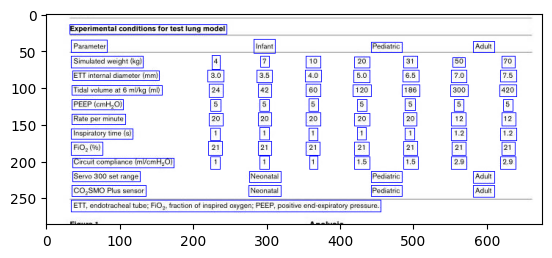

In [5]:
import cv2
import matplotlib.pyplot as plt
img_path = 'PMC1065056_table_0.jpg'
def draw_text_bbox_over_table(ocr_engine, image_path, show_image=False):
    alloutput = ocr_engine.ocr(image_path)
    output = alloutput[0]
    boxes = [line[0] for line in output]
    texts = [line[1][0] for line in output]
    probabilities = [line[1][1] for line in output]

    img = cv2.imread(image_path)
    image_boxes=img.copy()
    for box in boxes:
        cv2.rectangle(image_boxes, (int(box[0][0]),int(box[0][1])), (int(box[2][0]),int(box[2][1])),(0,0,255),1)
    if show_image:
        plt.imshow(image_boxes)
        plt.show()
    return image_boxes, boxes, alloutput

image_boxes, boxes, textoutputs = draw_text_bbox_over_table(ocr, img_path, show_image=True)

In [ ]:
from paddleocr import PaddleOCR
import cv2
import os
import pandas as pd

# Initialize the OCR model
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Load the original image
original_image = cv2.imread("PMC1065056_table_0.jpg")

# Load the segmentation mask and perform connected component labeling
img = cv2.imread("temp3.png", cv2.IMREAD_GRAYSCALE)  # Make sure the image is grayscale
n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=4)

# Create a directory to save cropped images
output_folder = "cropped_images"
os.makedirs(output_folder, exist_ok=True)

# Create a list to store the modified bounding boxes (expanded by 3 pixels)
expanded_bounding_boxes = []
text_arr = []

# Iterate over each labeled region in the sorted order
for index in range(1, n_labels):
    area = stats[index, cv2.CC_STAT_AREA]

    # Extract the original bounding box (x, y, w, h) for the current label
    x, y, w, h = stats[index, cv2.CC_STAT_LEFT], stats[index, cv2.CC_STAT_TOP], stats[index, cv2.CC_STAT_WIDTH], stats[index, cv2.CC_STAT_HEIGHT]

    # Expand the bounding box by 3 pixels in all directions
    x -= 4
    y -= 4
    w += 8
    h += 8

    expanded_bounding_boxes.append((x, y, w, h))
bbox=[]

# Crop the original image based on the modified bounding boxes and save them
for n, (x, y, w, h) in enumerate(expanded_bounding_boxes):
    crop = original_image[y:y+h, x:x+w]
    
    for i in range(crop.shape[0]):
        for j in range(crop.shape[1]):
            for k in range(crop.shape[2]):
                pixel_value = crop[i, j, k]
                if pixel_value < 180:
                    crop[i,j,k]=crop[i,j,k]=50
                else:
                    crop[i,j,k]=crop[i,j,k]=255
    try:
        # Upscale the image using bilinear interpolation
        scale_factor = 4
        upscaled_image = cv2.resize(crop, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)

        # apply OCR using PaddleOCR
        result = ocr.ocr(upscaled_image, cls=True)
        tuples = [res[0][-1] for res in result]

        # Extract and concatenate the OCR text
        CONTENT = ""
        for tpl in tuples:
            CONTENT = CONTENT + tpl[0]
        text_arr.append(CONTENT)
    except Exception as e:
        print(f"Error processing segment {n}: {e}")
        text_arr.append("")

    # Save the cropped image
    output_path = os.path.join(output_folder, f"segment_{n}.jpg")
    cv2.imwrite(output_path, crop)

# Create a DataFrame with order numbers, filenames, and OCR text
order_numbers = list(range(len(expanded_bounding_boxes)))
data = {'Order Number': order_numbers, 'Filename': [f"segment_{i}.jpg" for i in order_numbers], 'OCR_text': text_arr}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_filename = "segmentation_info.csv"
df.to_csv(csv_filename, index=False)

print("Cropped images saved to:", output_folder)
print("CSV file saved as:", csv_filename)


In [24]:
#[[[[32.0, 14.0], [246.0, 14.0], [246.0, 27.0], [32.0, 27.0]], ('Experimental conditions for test lung model', 0.9755704402923584)]
#[(36, 39, 167, 16),

def is_inside(rect1, rect2):
    """
    Check if rect1 (left_top1, left_bottom1, right_top1, right_bottom1) is inside rect2
    (left_top2, left_bottom2, right_top2, right_bottom2).
    """
    left_top1, left_bottom1, right_top1, right_bottom1 = rect1
    left_top2, left_bottom2, right_top2, right_bottom2 = rect2
    
    # Check if all four corners of rect1 are inside rect2
    return (left_top2[0] <= left_top1[0] <= right_top2[0] and
            left_top2[1] >= left_top1[1] >= left_bottom2[1] and
            left_top2[0] <= right_top1[0] <= right_top2[0] and
            left_top2[1] >= right_bottom1[1] >= left_bottom2[1])


count=0
for x in expanded_bounding_boxes:
    rect2=[(x[0],x[1]),(x[0],x[3]),(x[2],x[1]),(x[2],x[3])]
    for i in res:
        rect1=i[0]
        if is_inside(rect1,rect2)==True:
            count=count+1
    


In [25]:
print(count)

9


In [ ]:
# Assuming (x, y, w, h) are already defined
x1 = x + w  # Top-right x-coordinate
y1 = y      # Top-right y-coordinate

x2 = x + w  # Bottom-right x-coordinate
y2 = y + h  # Bottom-right y-coordinate

x3 = x      # Bottom-left x-coordinate
y3 = y + h  # Bottom-left y-coordinate

# Create the desired format
bounding_box_coordinates = [[x, y], [x1, y1], [x2, y2], [x3, y3]]


In [16]:
def intersection_area(box1, box2):
    # Extract coordinates for box 1
    x1, y1 = box1[0]
    x2, y2 = box1[1]
    x3, y3 = box1[2]
    x4, y4 = box1[3]

    # Extract coordinates for box 2
    x5, y5 = box2[0]
    x6, y6 = box2[1]
    x7, y7 = box2[2]
    x8, y8 = box2[3]

    # Calculate the intersection coordinates
    x_intersection = max(x1, x5)
    y_intersection = max(y1, y5)
    x2_intersection = min(x2, x6)
    y2_intersection = min(y3, y7)

    # Calculate the width and height of the intersection
    width = max(0, x2_intersection - x_intersection)
    height = max(0, y2_intersection - y_intersection)

    # Calculate the area of the intersection
    intersection_area = width * height

    return intersection_area

# Example usage:
box1 = [[0, 0], [4, 0], [4, 4], [0, 4]]
box2 = [[2, 2], [6, 2], [6, 6], [2, 6]]
text_arr=[]
for i in expanded_bounding_boxes:
    x1 = i[0] + i[2]  # Top-right x-coordinate
    y1 = i[1]      # Top-right y-coordinate

    x2 = i[0] + i[2]  # Bottom-right x-coordinate
    y2 = i[1] + i[3]  # Bottom-right y-coordinate

    x3 = i[0]      # Bottom-left x-coordinate
    y3 = i[1] + i[3]  # Bottom-left y-coordinate
    rect1 = [[i[0], i[1]], [x1, y1], [x2, y2], [x3, y3]]
    for j in res:
        rect2=j[0]
        if intersection_area(rect1,rect2)>90:
            text_arr.append(j[1])
print(text_arr)


[('Parameter', 0.9901752471923828), ('Infant', 0.9941168427467346), ('Pediatric', 0.9957953691482544), ('Adult', 0.9996689558029175), ('Simulated weight (kg)', 0.9048106670379639), ('4', 0.995421826839447), ('7', 0.9892626404762268), ('10', 0.9966083765029907), ('20', 0.995969295501709), ('31', 0.9953827857971191), ('50', 0.9989926815032959), ('04', 0.6739404201507568), ('ETT internal diameter (mm)', 0.9628220200538635), ('3.0', 0.9891681671142578), ('3.5', 0.9421882629394531), ('4.0', 0.988450825214386), ('5.0', 0.9909430146217346), ('6.5', 0.9849910140037537), ('7.0', 0.9872816205024719), ('7.5', 0.9591720700263977), ('Tidal volume at 6 ml/kg (ml', 0.9075518250465393), ('24', 0.9972919225692749), ('42', 0.9974846839904785), ('09', 0.9820802211761475), ('120', 0.9966920018196106), ('186', 0.9949440360069275), ('300', 0.9981479644775391), ('420', 0.9981870651245117), ('PEEP cmHO', 0.9363825917243958), ('5', 0.9978269934654236), ('5', 0.9966344237327576), ('5', 0.9962712526321411), ('5'